# Challenge MNIST-10

**Author**: Tristan PERROT \
Data available on [Challenge Date ENS](https://challengedata.ens.fr/participants/challenges/118/)

## Description

Le but du challenge MNIST-10 est de développer un algorithme apprenant à reconnaître les images de 0 à 9.

## Import des librairies

In [2]:
import csv
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
from tqdm.notebook import tqdm, trange
import optuna

# See cuda version
print("CUDA Version:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

CUDA Version: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load the data

In [5]:
DATA_DIR = ""

# Load data
with open(os.path.join(DATA_DIR, "train.csv"), "r") as f:
    reader = csv.reader(f)
    next(reader)
    data = [row for row in reader]

x_train = np.array([row[1:] for row in data], dtype=np.float32)
y_train = np.array([row[0] for row in data], dtype=np.int32)

with open(os.path.join(DATA_DIR, "test.csv"), "r") as f:
    reader = csv.reader(f)
    next(reader)
    X_test_final = np.array([row for row in reader], dtype=np.float32)

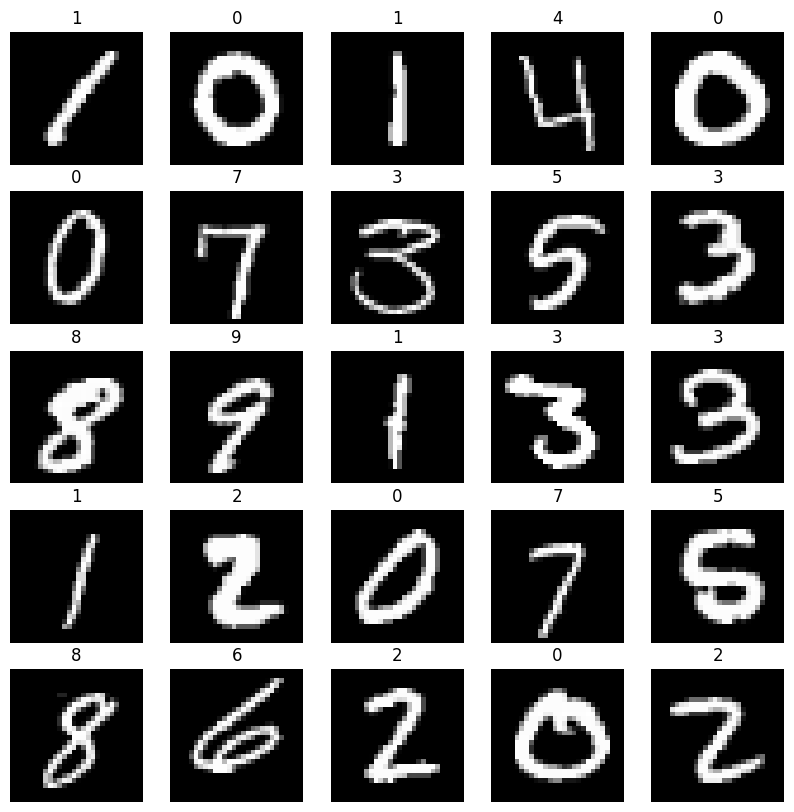

In [6]:
# Show images and label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

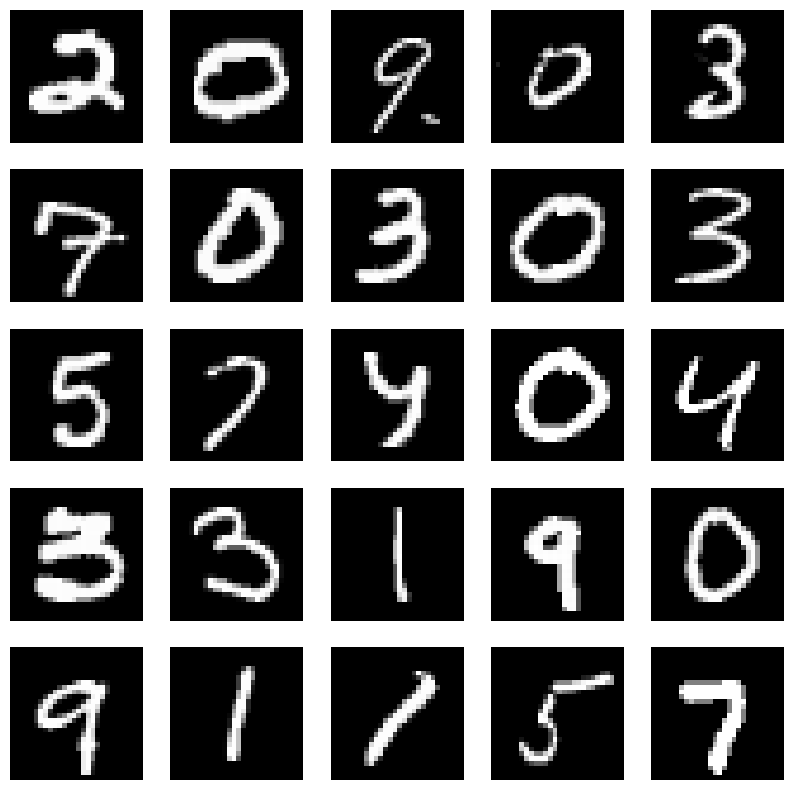

In [7]:
# Show test images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test_final[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

## Preprocessing

In [11]:
# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
X_test_final = scaler.transform(X_test_final)

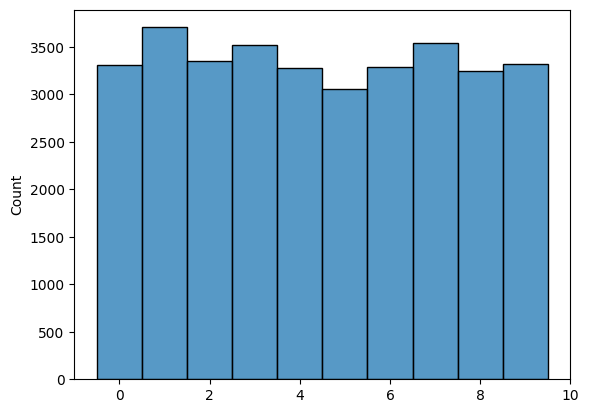

In [12]:
# Display distribution of labels
sns.histplot(y_train, discrete=True)
plt.show()

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2)

## Train

### Test An ensemble of CNNs with Batch Normalization and Learning Rate Annealer

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Model with an ensemble of CNNs with Batch Normalization and Learning Rate Annealer and Data Augmentation
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Learning rate annealer
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1, mode='min')

x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# Train the model
def train_model(x_train, y_train, x_val, y_val, batch_size=64):
    model = create_model()

    # Fit the data generator after reshaping
    datagen.fit(x_train)
    
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
              epochs=40, 
              validation_data=(x_val, y_val),
              callbacks=[reduce_lr, es])
    
    return model

In [17]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                                                      

In [18]:
model = train_model(x_train, y_train, x_val, y_val, batch_size=64)

Epoch 1/40
420/420 [==============================] - 10s 15ms/step - loss: 0.3115 - accuracy: 0.9032 - val_loss: 0.1594 - val_accuracy: 0.9484 - lr: 0.0010
Epoch 2/40
420/420 [==============================] - 6s 14ms/step - loss: 0.1209 - accuracy: 0.9629 - val_loss: 0.0702 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 3/40
420/420 [==============================] - 6s 13ms/step - loss: 0.0898 - accuracy: 0.9728 - val_loss: 0.0769 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 4/40
420/420 [==============================] - 6s 14ms/step - loss: 0.0749 - accuracy: 0.9765 - val_loss: 0.0809 - val_accuracy: 0.9765 - lr: 0.0010
Epoch 5/40
420/420 [==============================] - 6s 14ms/step - loss: 0.0686 - accuracy: 0.9780 - val_loss: 0.0625 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 6/40
420/420 [==============================] - 6s 14ms/step - loss: 0.0555 - accuracy: 0.9829 - val_loss: 0.0493 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 7/40
420/420 [==============================] - 6s 14ms/s

In [19]:
# Predict the test data
X_test_final = X_test_final.reshape(-1, 28, 28, 1)
y_pred = model.predict(X_test_final)
y_pred = np.argmax(y_pred, axis=1)

875/875 [==============================] - 1s 1ms/step


### Test an inception model of CNNs with Batch Normalization and Learning Rate Annealer and Data Augmentation and Dropout and Maxout and Stochastic Weight Averaging

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the Inception-A module
def inception_a(x, filters):
    branch1x1 = tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch5x5 = tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = tf.keras.layers.Conv2D(filters[1], (5, 5), padding='same', activation='relu')(branch5x5)

    branch3x3 = tf.keras.layers.Conv2D(filters[2], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)
    branch3x3 = tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch_pool = tf.keras.layers.AvgPool2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(branch_pool)

    x = tf.keras.layers.Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
    return x

# Define the Reduction-A module
def reduction_a(x, k, l, m, n):
    branch3x3 = tf.keras.layers.Conv2D(n, (3, 3), strides=(2, 2), padding='valid', activation='relu')(x)

    branch3x3dbl = tf.keras.layers.Conv2D(k, (1, 1), padding='same', activation='relu')(x)
    branch3x3dbl = tf.keras.layers.Conv2D(l, (3, 3), padding='same', activation='relu')(branch3x3dbl)
    branch3x3dbl = tf.keras.layers.Conv2D(m, (3, 3), strides=(2, 2), padding='valid', activation='relu')(branch3x3dbl)

    branch_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    x = tf.keras.layers.Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
    return x

# Define the Inception-B module
def inception_b(x, filters):
    branch1x1 = tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch7x7 = tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch7x7 = tf.keras.layers.Conv2D(filters[1], (1, 7), padding='same', activation='relu')(branch7x7)
    branch7x7 = tf.keras.layers.Conv2D(filters[1], (7, 1), padding='same', activation='relu')(branch7x7)

    branch7x7dbl = tf.keras.layers.Conv2D(filters[2], (1, 1), padding='same', activation='relu')(x)
    branch7x7dbl = tf.keras.layers.Conv2D(filters[2], (7, 1), padding='same', activation='relu')(branch7x7dbl)
    branch7x7dbl = tf.keras.layers.Conv2D(filters[2], (1, 7), padding='same', activation='relu')(branch7x7dbl)
    branch7x7dbl = tf.keras.layers.Conv2D(filters[2], (7, 1), padding='same', activation='relu')(branch7x7dbl)
    branch7x7dbl = tf.keras.layers.Conv2D(filters[2], (1, 7), padding='same', activation='relu')(branch7x7dbl)

    branch_pool = tf.keras.layers.AvgPool2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(branch_pool)

    x = tf.keras.layers.Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
    return x

# Define the Reduction-B module
def reduction_b(x):
    branch3x3 = tf.keras.layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = tf.keras.layers.Conv2D(320, (3, 3), strides=(2, 2), padding='valid', activation='relu')(branch3x3)

    branch7x7x3 = tf.keras.layers.Conv2D(192, (1, 1), padding='same', activation='relu')(x)
    branch7x7x3 = tf.keras.layers.Conv2D(192, (1, 7), padding='same', activation='relu')(branch7x7x3)
    branch7x7x3 = tf.keras.layers.Conv2D(192, (7, 1), padding='same', activation='relu')(branch7x7x3)
    branch7x7x3 = tf.keras.layers.Conv2D(192, (3, 3), strides=(2, 2), padding='valid', activation='relu')(branch7x7x3)

    branch_pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    x = tf.keras.layers.Concatenate(axis=-1)([branch3x3, branch7x7x3, branch_pool])
    return x

# Define the Inception-C module
def inception_c(x, filters):
    branch1x1 = tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3_1 = tf.keras.layers.Conv2D(filters[1], (1, 3), padding='same', activation='relu')(branch3x3)
    branch3x3_2 = tf.keras.layers.Conv2D(filters[1], (3, 1), padding='same', activation='relu')(branch3x3)

    branch3x3dbl = tf.keras.layers.Conv2D(filters[2], (1, 1), padding='same', activation='relu')(x)
    branch3x3dbl = tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3dbl)
    branch3x3dbl_1 = tf.keras.layers.Conv2D(filters[2], (1, 3), padding='same', activation='relu')(branch3x3dbl)
    branch3x3dbl_2 = tf.keras.layers.Conv2D(filters[2], (3, 1), padding='same', activation='relu')(branch3x3dbl)

    branch_pool = tf.keras.layers.AvgPool2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(branch_pool)

    x = tf.keras.layers.Concatenate(axis=-1)([branch1x1, branch3x3_1, branch3x3_2, branch3x3dbl_1, branch3x3dbl_2, branch_pool])
    return x

# Define the stem module
def inception_stem(x):
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='valid', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.Conv2D(80, (1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(192, (3, 3), padding='valid', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)
    return x

# Inception-v4 Model
def create_inception_v4():
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))

    x = inception_stem(input_layer)

    x = tf.keras.layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    x = inception_a(x, [64, 64, 96, 32])
    x = inception_a(x, [64, 64, 96, 64])
    x = inception_a(x, [64, 64, 96, 64])
    x = inception_a(x, [64, 64, 96, 64])

    x = reduction_a(x, 96, 128, 160, 192)

    x = inception_b(x, [192, 128, 160, 128])
    x = inception_b(x, [192, 160, 192, 160])
    x = inception_b(x, [192, 160, 192, 160])
    x = inception_b(x, [192, 160, 192, 160])
    x = inception_b(x, [192, 160, 192, 160])
    x = inception_b(x, [192, 160, 192, 160])
    x = inception_b(x, [192, 160, 192, 160])

    x = reduction_b(x)

    x = inception_c(x, [256, 256, 384, 128])
    x = inception_c(x, [256, 256, 384, 128])
    x = inception_c(x, [256, 256, 384, 128])

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

# Learning rate annealer
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=float("-inf"))

# Prepare the data
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

# Train the model
def train_inception_v4(x_train, y_train, x_val, y_val, batch_size):
    model = create_inception_v4()

    # Fit the data generator after reshaping
    datagen.fit(x_train)

    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
              epochs=40,
              validation_data=(x_val, y_val),
              callbacks=[reduce_lr])

    return model


In [45]:
model = create_inception_model()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_248 (Conv2D)            (None, 28, 28, 32)   320         ['input_14[0][0]']               
                                                                                                  
 batch_normalization_39 (BatchN  (None, 28, 28, 32)  128         ['conv2d_248[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_70 (MaxPooling2D  (None, 14, 14, 32)  0           ['batch_normalization_39[0

In [46]:
# Train and evaluate the Inception model
model = train_inception_model(x_train, y_train, x_val, y_val, batch_size=64)


Epoch 1/40
420/420 [==============================] - 8s 16ms/step - loss: 0.3022 - accuracy: 0.9092 - val_loss: 0.2356 - val_accuracy: 0.9374 - lr: 0.0010
Epoch 2/40
420/420 [==============================] - 7s 16ms/step - loss: 0.0914 - accuracy: 0.9723 - val_loss: 0.1683 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 3/40
420/420 [==============================] - 7s 16ms/step - loss: 0.0646 - accuracy: 0.9807 - val_loss: 0.1370 - val_accuracy: 0.9601 - lr: 0.0010
Epoch 4/40
420/420 [==============================] - 7s 16ms/step - loss: 0.0540 - accuracy: 0.9829 - val_loss: 0.0833 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/40
420/420 [==============================] - 7s 16ms/step - loss: 0.0473 - accuracy: 0.9848 - val_loss: 0.0867 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/40
420/420 [==============================] - 6s 15ms/step - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.0649 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 7/40
420/420 [==============================] - 6s 15ms/st

In [33]:
# Predict the test data
X_test_final = X_test_final.reshape(-1, 28, 28, 1)
y_pred = model.predict(X_test_final)
y_pred = np.argmax(y_pred, axis=1)

875/875 [==============================] - 4s 4ms/step


## Submission

In [34]:
# Save the predictions to a CSV file
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['ImageId', 'Label'])
    for i, label in enumerate(y_pred):
        writer.writerow([i+1, label])